## Project: Sign language exercise

---
### 1. Import the libraries that we need

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy

from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 1
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)
# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.compat.v1.set_random_seed(seed_value)

### 2. Data preparation

In [4]:
train_path  = 'dataset/sorted_train_colored_picked'
# valid_path  = 'dataset/valid'
test_path  = 'dataset/sorted_test'

In [5]:
# ImageDataGenerator generates batches of tensor image data with real-time data augmentation. 
# The data will be looped over (in batches).
# in this example, we won't be doing any image augmentation
# train_batches = ImageDataGenerator().flow_from_directory(train_path, 
#                                                          target_size=(224,224), 
#                                                          batch_size=10)

# valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
#                                                          target_size=(224,224), 
#                                                          batch_size=30)

# test_batches = ImageDataGenerator().flow_from_directory(test_path, 
#                                                         target_size=(224,224), 
#                                                         batch_size=50, 
#                                                         shuffle=False)

In [6]:
train_datagen = ImageDataGenerator(
    # rescale=1./255,
    # shear_range=0.2,
    zoom_range=0.5,
    # rotation_range=15,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    horizontal_flip=True,
    # vertical_flip=True,
    validation_split=0.1)

    

train_batches = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=128,
    subset='training') # set as training data

valid_batches = train_datagen.flow_from_directory(
    train_path, # same directory as training data
    target_size=(224, 224),
    batch_size=128,
    subset='validation') # set as validation data

test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224,224), 
                                                        batch_size=50, 
                                                        shuffle=False)

Found 2983 images belonging to 4 classes.
Found 330 images belonging to 4 classes.
Found 492 images belonging to 4 classes.


### 3. VGG16 base model pre-trained on ImageNet dataset

In [7]:
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3), pooling='avg')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### 2. freeze the classification layers in the base model

In [8]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers[:-5]:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
# use “get_layer” method to save the last layer of the network
last_layer = base_model.get_layer('global_average_pooling2d')

# save the output of the last layer to be the input of the next layer
last_output = last_layer.output

# x = Flatten()(last_output) # Flatten dimensions to for use in FC layers
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
# x = Dense(256, activation='relu')(x)
# x = Dense(4, activation='softmax')(x) # Softmax for multiclass

# add our new softmax layer with 3 hidden units
x = Dense(4, activation='softmax', name='softmax')(last_output)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)

# print the new_model summary
new_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### 4. Train the new model

In [10]:
new_model.compile(Adam(lr=0.0001, decay=0.1), loss='categorical_crossentropy', metrics=['accuracy']) # type: ignore

c:\Users\Ricky\anaconda3\envs\python3.7\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
from sklearn.utils import class_weight 

class_weights = class_weight.compute_class_weight(
           class_weight='balanced',
            classes=np.unique(train_batches.classes), 
            y=train_batches.classes)

train_class_weights = dict(enumerate(class_weights))

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# checkpointer = ModelCheckpoint(filepath=r'vgg16.model.hdf5', verbose=1, save_best_only=True)
escallback = EarlyStopping(monitor='val_loss', patience=30)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=30, verbose=1, mode='max', min_lr=5e-5)
checkpointer = ModelCheckpoint(filepath=r'vgg16.model.hdf5', save_best_only = True, verbose= 1)

history = new_model.fit_generator(train_batches, steps_per_epoch=train_batches.samples/train_batches.batch_size,
                   validation_data=valid_batches, 
                   validation_steps=valid_batches.samples/valid_batches.batch_size, 
                   epochs=300, 
                   verbose=1,
                #    class_weight=train_class_weights,
                   callbacks=[checkpointer, escallback])

c:\Users\Ricky\anaconda3\envs\python3.7\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/300
23/23 [==============================] - 67s 2s/step - loss: 1.4911 - accuracy: 0.3859 - val_loss: 1.1941 - val_accuracy: 0.5182

Epoch 00001: val_loss improved from inf to 1.19406, saving model to vgg16.model.hdf5
Epoch 2/300
23/23 [==============================] - 23s 987ms/step - loss: 1.2032 - accuracy: 0.5092 - val_loss: 1.0749 - val_accuracy: 0.5970

Epoch 00002: val_loss improved from 1.19406 to 1.07493, saving model to vgg16.model.hdf5
Epoch 3/300
23/23 [==============================] - 23s 986ms/step - loss: 1.1298 - accuracy: 0.5619 - val_loss: 1.0142 - val_accuracy: 0.6394

Epoch 00003: val_loss improved from 1.07493 to 1.01417, saving model to vgg16.model.hdf5
Epoch 4/300
23/23 [==============================] - 23s 994ms/step - loss: 1.0904 - accuracy: 0.5682 - val_loss: 0.9996 - val_accuracy: 0.6091

Epoch 00004: val_loss improved from 1.01417 to 0.99959, saving model to vgg16.model.hdf5
Epoch 5/300
23/23 [==============================] - 23s 982ms/step - l

### 5. create the confusion matrix to evaluate the model

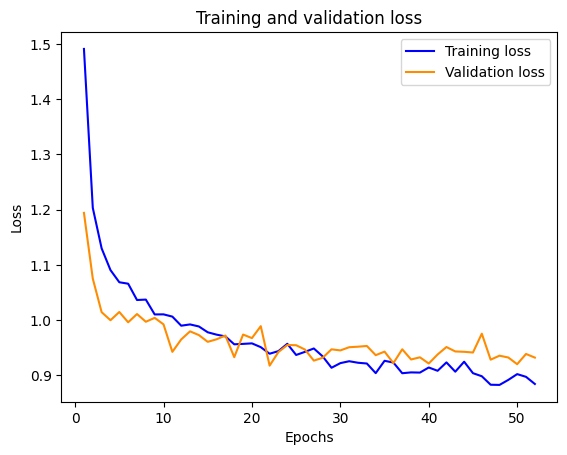

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

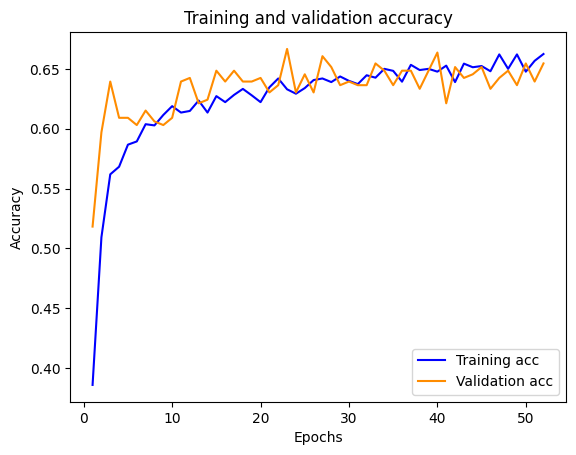

In [14]:
plt.clf()   # clear figure
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'darkorange', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [15]:
print(min(val_loss))
print(max(val_acc))

0.9173008799552917
0.6666666865348816


In [16]:
def load_dataset(path, categories=None):
    data = load_files(path, categories=categories)
    paths = np.array(data['filenames'])
    targets = to_categorical(np.array(data['target']))
    return paths, targets

In [24]:
from sklearn.datasets import load_files
from tensorflow.keras.utils import to_categorical
import numpy as np

test_files, test_targets = load_dataset('dataset/test_sorted_new')

In [25]:
test_files

array(['dataset/test_sorted_new\\2\\362.png',
       'dataset/test_sorted_new\\0\\67.png',
       'dataset/test_sorted_new\\2\\320.png',
       'dataset/test_sorted_new\\1\\144.png',
       'dataset/test_sorted_new\\0\\111.png',
       'dataset/test_sorted_new\\3\\464.png',
       'dataset/test_sorted_new\\1\\141.png',
       'dataset/test_sorted_new\\3\\454.png',
       'dataset/test_sorted_new\\0\\117.png',
       'dataset/test_sorted_new\\3\\434.png',
       'dataset/test_sorted_new\\3\\418.png',
       'dataset/test_sorted_new\\2\\316.png',
       'dataset/test_sorted_new\\1\\159.png',
       'dataset/test_sorted_new\\0\\70.png',
       'dataset/test_sorted_new\\1\\134.png',
       'dataset/test_sorted_new\\3\\424.png',
       'dataset/test_sorted_new\\2\\261.png',
       'dataset/test_sorted_new\\2\\250.png',
       'dataset/test_sorted_new\\2\\233.png',
       'dataset/test_sorted_new\\2\\322.png',
       'dataset/test_sorted_new\\2\\254.png',
       'dataset/test_sorted_new\\2\\

In [26]:
from tensorflow.keras.preprocessing import image  
from tensorflow.keras.applications.vgg16 import preprocess_input
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))

100%|██████████| 492/492 [00:01<00:00, 391.08it/s]


In [27]:
new_model.load_weights('vgg16.model.hdf5')

In [28]:
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets)))

16/16 [==============================] - 1s 69ms/step - loss: 0.9656 - accuracy: 0.6199

Testing loss: 0.9656
Testing accuracy: 0.6199


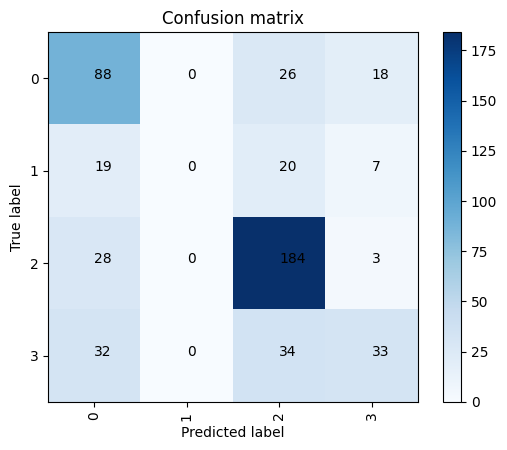

In [29]:
from sklearn.metrics import confusion_matrix

cm_labels = ['0','1','2','3']

cm = confusion_matrix(np.argmax(test_targets, axis=1),
                      np.argmax(new_model.predict(test_tensors), axis=1))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
indexes = np.arange(len(cm_labels))
for i in indexes:
    for j in indexes:
        plt.text(j, i, cm[i, j])
plt.xticks(indexes, cm_labels, rotation=90)
plt.xlabel('Predicted label')
plt.yticks(indexes, cm_labels)
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [23]:
test_files, test_targets = load_dataset('dataset', 'test')
test_files = sorted(test_files, key=lambda x:int(x.split('\\')[2].split('.')[0]))
test_tensors = preprocess_input(paths_to_tensor(test_files))

predict =new_model.predict(test_tensors)
y_classes = predict.argmax(axis=-1)
predict
import pandas as pd
result = pd.read_csv('sample_submission.csv')
result['Type'] = y_classes
result.to_csv('vgg16.csv', index=None)

100%|██████████| 492/492 [00:00<00:00, 1645.49it/s]


### The End!